## Used to create plots perform analysis of output produced by model based on dose variations
- Output data will be saved as files and then imported here to analyse/plot.

In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

mystyle = r'https://gist.githubusercontent.com/mbolt01/3087dffd11e70eccb08fdcf327374a5c/raw/std_fig'
plt.style.use(mystyle)

## can do my modelling in this notebook too.
import TCP_NTCP as model

In [2]:
## functions to simply save and load files for use aftger producing modelling results

def save_pkl(obj,filename):
    pickle.dump(obj,open(filename,'wb'))

def load_pkl(filename):
    return pickle.load(open(filename,'rb'))

## example save:
#save_pkl(prost_10year,'test3.pkl')
## example load:
#newtest = load_pkl('test3.pkl')


## define colours to use for each type
color_p = 'C0'
color_hn = 'C1'

# Variation in doses
- Convolution of the different sources of dose variation.
    - Variation assumed to be normally distributed with standard deviations of:
        - Beam calibration: % (SD from NPL data) 
        - Output offset: % (variaiton in mean dose observed over a 2 month period for all meachines)
        - Daily variations: % (mean SD based on each machines farmer data)
- Convolution of normal distributions means just adding together the variances = SD^2
    - Total SD = sqrt(SD1^2 + SD2^2 + ...SDn^2)
    - https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables#Independent_random_variables
    - http://mathworld.wolfram.com/NormalSumDistribution.html

In [3]:
## NPL MV data
## From the NPL Data the SD of the MV beam outputs is 0.7% (section 3.2.1)

## Systematic beam output
## From the first 7 weeks of output data this gives 0.7% also (section 4.3.7.2)

## Daily output fluctuations
## From the farmer chamber 0.2% (section 4.3.8)

npl_err = 0.7
op_err = 0.7
rand_err = 0.2

## convolute the erros together to give combined SDs
print('NPL only SD: ',npl_err)
npl_conv_op = np.sqrt(npl_err**2 + op_err**2)
print('NPL + Output SD: ',npl_conv_op)
npl_conv_op_conv_rand = np.sqrt(npl_err**2 + op_err**2 + rand_err**2)
print('NPL + Output + random SD: ',npl_conv_op_conv_rand)

print('--')
## produce 95% CI
print('NPL only 95%CI: ',npl_err*1.96)
print('NPL + Output 95%CI: ',npl_conv_op*1.96)
print('NPL + Output + random 95%CI: ',npl_conv_op_conv_rand*1.96)

## values to use:
print('--')
print('NPL only 95%CI use: ',1.4)
print('NPL + Output 95%CI use: ',1.9)
print('NPL + Output + random 95%CI use: ',2)

NPL only SD:  0.7
NPL + Output SD:  0.989949493661
NPL + Output + random SD:  1.00995049384
--
NPL only 95%CI:  1.3719999999999999
NPL + Output 95%CI:  1.94030100758
NPL + Output + random 95%CI:  1.97950296792
--
NPL only 95%CI use:  1.4
NPL + Output 95%CI use:  1.9
NPL + Output + random 95%CI use:  2


# Varied dose SD, fixed other parameters for a population
- Used to assess change in number of patients with a particular probability of getting a TCP outcome.
- From MALTHUS: extrapolate to 2015 for prostate and H&N.
    - Prostate: No. RT patients: 26486
    - H&N: No. RT patients: 8044
- From other simulations in thesis: a/b's = 1.5 (0.75 SD), 10 (1 SD) which were fitted to clinical data

In [24]:
## model a fixed population (fixed set of a/b ratios) with systematic shifts in dose.
## record the mean and also number >20%,80%, 90% etc.
## this would be like the same set of patients being treated on different linacs

n_p = 2631#8 #26318 fro malthus
n_hn = 809#3 #8093 from malthus

## creates array of [alpha,beta values]
ab_p = model.create_alpha_beta_array(n_p,1.5,100*0.75/1.5) 
ab_hn = model.create_alpha_beta_array(n_hn,10,100*1/10)

## create list of a/b values
ab_ratios_p = [i[0]/i[1] for i in ab_p]
ab_ratios_hn = [i[0]/i[1] for i in ab_hn]

my_d_shifts = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
all_res_p = {}
all_res_hn = {}
for my_d_shift in my_d_shifts:
    print(my_d_shift)
    
    tcps_p = []
    tcps_hn = []
    
    ## prostate
    for i in range(n_p):
        results_p = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                          alphabeta_use=ab_ratios_p[i],      # mean alpha/beta
                                          alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                          d=2,                    # nominal dose (Gy/fraction)
                                          d_shift=my_d_shift,          # initial dose difference (%)
                                          d_sd=0,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 74)                # N0 as determnined through population fit
        tcps_p.append(results_p['TCPs'][0])
    
    ## head and neck
    for j in range(n_hn):
        results_hn = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                          alphabeta_use=ab_ratios_hn[j],      # mean alpha/beta
                                          alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                          d=65/30,                    # nominal dose (Gy/fraction)
                                          d_shift=my_d_shift,          # initial dose difference (%)
                                          d_sd=0,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 3000000)                # N0 as determnined through population fit
        tcps_hn.append(results_hn['TCPs'][0])
    
    all_res_p[my_d_shift]=tcps_p
    all_res_hn[my_d_shift]=tcps_hn


-5
-4
-3
-2
-1
0
1
2
3
4
5


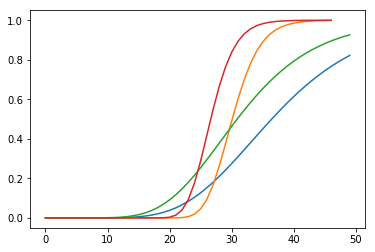

In [3]:
#save_pkl(all_res_p,'pop_results-p.pkl')
#save_pkl(all_res_hn,'pop_results-hn.pkl')
all_res_p = load_pkl('pop_results-p.pkl')
all_res_hn = load_pkl('pop_results-hn.pkl')
## example plot of population means of +/-5% dose shift
for i in [-5,5]:
    plt.plot(np.mean(all_res_p[i],axis=0))
    plt.plot(np.mean(all_res_hn[i],axis=0))

8093
8093
8093


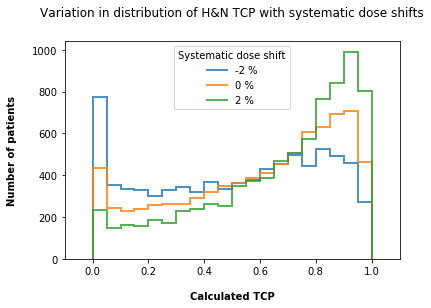

In [60]:
## prost = [36]
## hn = [29]
## a single curve is all_res_p[dose_shift][i] ## i is the ith patient

## get mean, number above 90%, below 10%
## prost
## get only values at dose of interest
#all_res_hn[0][0][36]
dose_shift=0

colors = ['C0','C1','C2']

i=0
for dose_shift in [-2,0,2]:

    for data in [all_res_hn]:#,all_res_hn]:
    #data = all_res_p
        if data == all_res_hn:
            posn = 29
            label=str(dose_shift) + ' %'
            title = 'Variation in distribution of H&N TCP with systematic dose shifts'
        else:
            posn = 36
            label=str(dose_shift) + ' %'
            title = 'Variation in distribution of Prostate TCP with systematic dose shifts'
        tcps = [data[dose_shift][i][posn] for i in range(len(data[dose_shift]))]
        print(len(tcps))
        plt.hist(tcps,normed=False,alpha=0.8,bins=20,range=(0,1),histtype='step',lw=2,color=colors[i])
        plt.plot([10,10],[10,10],lw=2,alpha=0.8,label=label,color=colors[i])
        i=i+1
plt.xlim(-0.1,1.1)
#plt.axvline(0.2,c='black',ls=':',lw=1)
#plt.axvline(0.8,c='black',ls=':',lw=1)
plt.legend(title='Systematic dose shift',loc='upper center')
plt.ylabel('Number of patients')
plt.xlabel('Calculated TCP')
plt.title(title)
#plt.savefig('population tcp change with dose shift-line.png',dpi=300,bbox_inches='tight')
plt.show()

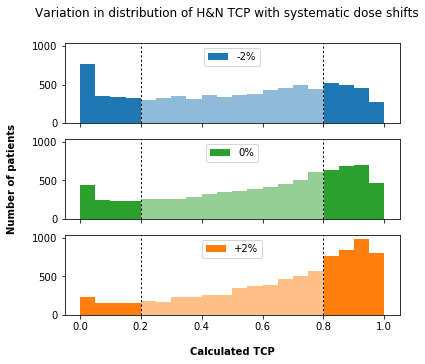

In [59]:
## prost = [36]
## hn = [29]
## a single curve is all_res_p[dose_shift][i] ## i is the ith patient

## get mean, number above 90%, below 10%
## prost
## get only values at dose of interest
#all_res_hn[0][0][36]
dose_shift=0

tcps0=tcps = [data[0][i][29] for i in range(len(data[0]))]
tcps2=tcps = [data[2][i][29] for i in range(len(data[2]))]
tcps_2=tcps = [data[-2][i][29] for i in range(len(data[-2]))]
colors = ['C0','C2','C1']
all_data = [tcps_2,tcps0,tcps2]
labels = ['-2%','0%','+2%']

fig, ax = plt.subplots(nrows=3,sharex=True,figsize=(6,5),sharey=True)

j=0
for plotdata in all_data:
    ax[j].hist(plotdata,bins=20,range=(0,1),color=colors[j],label=labels[j])
    ax[j].axvline(0.2,ls=':',lw=1,color='black')
    ax[j].axvline(0.8,ls=':',lw=1,color='black')
    ax[j].axvspan(0.2,0.8,color='white',alpha=0.5)
    ax[j].legend(loc='upper center')
    j=j+1
    
#plt.xlim(-0.1,1.1)
#plt.legend(title='Systematic dose shift',loc='upper center')
ax[1].set_ylabel('Number of patients')
plt.xlabel('Calculated TCP')
plt.suptitle(title)
#plt.savefig('population tcp change with dose shift-3plots.png',dpi=300,bbox_inches='tight')
plt.show()

In [125]:
## calculate umber of patients <20% and >80% TCP for p and h&n for each dose shift

## loop each dose shift

for data in [all_res_p,all_res_hn]:
    #data = all_res_p
    for dose in sorted(data):
        ## get list of TCPs at required points
        if data == all_res_p:
            posn = 36
            label='Prost'
        else:
            posn = 29
            label='H&N'
        tcps = [data[dose][i][posn] for i in range(len(data[dose]))]
        tcps_lt20 = len([i for i in tcps if i<0.2])
        tcps_gt80 = len([i for i in tcps if i>0.8])
        print(label,dose,tcps_lt20,tcps_gt80)

Prost -5 3954 3831
Prost -4 3237 4170
Prost -3 2611 4560
Prost -2 1992 5002
Prost -1 1507 5480
Prost 0 1101 5980
Prost 1 758 6510
Prost 2 485 7074
Prost 3 307 7723
Prost 4 153 8330
Prost 5 71 8980
H&N -5 3014 866
H&N -4 2568 1104
H&N -3 2153 1418
H&N -2 1788 1747
H&N -1 1445 2077
H&N 0 1146 2491
H&N 1 904 2938
H&N 2 700 3403
H&N 3 540 3834
H&N 4 397 4254
H&N 5 295 4680


# Fixed dose/# with % dose shift (e.g. cal dif or output difference)
- Do for H&N and prost.
- Store the results for each run in dict (and save)
- Can then compare TCP at given dose and see spread or plot different shifts etc.
- Do a run where dose shifta are drawn from a normal dist (NPL + output convolution)
    - This will show variations for a single patient depended on where treated

In [4]:
## prostate

## dict to store results

do_this = True
if do_this == True:
    res_p = {}

    ## dose shifts to apply (same for each fraciton as no SD)
    d_shifts = np.arange(-5,5,0.25)
    print('dose shifts: ',d_shifts)

    for the_d in d_shifts:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=1.5,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 74)                # N0 as determnined through population fit
        res_p[the_d] = results

    print('Prostate done')

    ## H&N 
    ## dict to store results
    res_hn = {}

    for the_d in d_shifts:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=10,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=65/30,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 3000000)                # N0 as determnined through population fit
        res_hn[the_d] = results

    print('H&N done')


dose shifts:  [-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]
Prostate done
H&N done


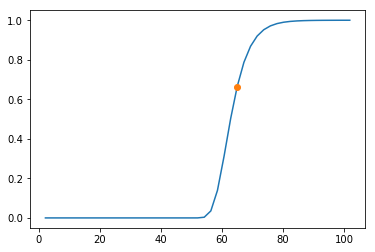

In [5]:
plt.plot(res_hn[0]['nom_doses'],res_hn[0]['TCP_pop'])
plt.plot(65,0.66,'o')
plt.show()

In [4]:
## Save/Load data

# save:
#save_pkl(res_p,'prost_d_shift_var.pkl')
#save_pkl(res_hn,'hn_d_shift_var.pkl')

## load:
res_p = load_pkl('prost_d_shift_var.pkl')
res_hn = load_pkl('hn_d_shift_var.pkl')

shift: -0.75 p -2.58053006088 hn -5.89425199745
shift: -0.5 p -1.71197632473 hn -3.87945960051
shift: 2.0 p 6.50152611449 hn 13.4825799097
shift: 3.0 p 9.53836091958 hn 19.0348093712
shift: 4.0 p 12.4300555459 hn 23.8553408559
shift: -4.0 p -14.5773657581 hn -35.9268668117
shift: -0.25 p -0.851769220148 hn -1.9145055022
shift: 1.5 p 4.92911209362 hn 10.4154247755
shift: -2.0 p -7.04483780624 hn -16.6796758044
shift: 1.25 p 4.12953141801 hn 8.80683326709
shift: 2.25 p 7.2742796692 hn 14.9423094775
shift: 2.75 p 8.79272100018 hn 17.7176115786
shift: -1.25 p -4.34227938425 hn -10.0698950143
shift: 3.25 p 10.2749235092 hn 20.3062178211
shift: 4.25 p 13.1302401219 hn 24.9533941486
shift: 0.75 p 2.50386437844 hn 5.43745548185
shift: -3.0 p -10.7547198346 hn -26.0602777644
shift: 4.5 p 13.8213356064 hn 26.0107056582
shift: 0.0 p 0.0 hn 0.0
shift: 0.5 p 1.67789207062 hn 3.67614820011
shift: 3.5 p 11.0023972471 hn 21.5327814667
shift: 3.75 p 11.7207753317 hn 22.7154838777
shift: 1.0 p 3.3210974

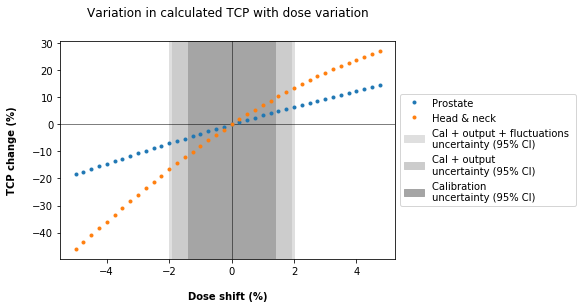

In [6]:
## plot the calcualted TCP (in percentage) against the dose shift (%)

tcp_percs_p = []
orig_tcp_p = res_p[0]['TCP_cure_percent']
tcp_percs_hn = []
orig_tcp_hn = res_hn[0]['TCP_cure_percent']

## get the dose shifts from the saved data
d_shifts = [i for i in res_p.keys()]

for i in d_shifts:
    ## prost
    the_tcp_p = res_p[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_p = ((the_tcp_p/orig_tcp_p)-1)*100
    tcp_percs_p.append(tcp_perc_dif_p)
    ## hn
    the_tcp_hn = res_hn[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_hn = ((the_tcp_hn/orig_tcp_hn)-1)*100
    tcp_percs_hn.append(tcp_perc_dif_hn)
    print('shift:',i,'p',tcp_perc_dif_p,'hn',tcp_perc_dif_hn)
    
plt.plot(d_shifts,tcp_percs_p,'o',ms=3,label='Prostate',color=color_p)
plt.plot(d_shifts,tcp_percs_hn,'o',ms=3,label='Head & neck',color=color_hn)
plt.title('Variation in calculated TCP with dose variation')
plt.ylabel('TCP change (%)')
plt.xlabel('Dose shift (%)')

plt.axhline(0,color='black',lw=0.5,zorder=0)
plt.axvline(0,color='black',lw=0.5,zorder=0)

#plt.ylim(-40,40)

## add a polynomial...
## do the polynomial fit and create function from it

add_fit = False
if add_fit == True:
    for i in [tcp_percs_p,tcp_percs_hn]:
        coefs = poly.polyfit(d_shifts, i, 2)
        ffit = poly.Polynomial(coefs)
        if i == tcp_percs_p:
            fit_color = color=color_p
        else:
            fit_color = color=color_hn
        ## generate some x values and then plot the curve at these points
        x_fit = np.linspace(start=min(d_shifts),stop=max(d_shifts),num=100,endpoint=True)

        plt.plot(x_fit, ffit(x_fit),color=fit_color,lw=1,zorder=0)
    
## shade the regions of interest with different colours and labels
output_errors = {1.4:{'label':'Calibration \nuncertainty (95% CI)',
                    'color':'#a5a5a5'},
                 1.9:{'label':'Cal + output \nuncertainty (95% CI)',
                   'color':'#cccccc'},
                2:{'label':'Cal + output + fluctuations \nuncertainty (95% CI)',
                   'color':'#dfdfdf'}}

for val in sorted(output_errors,reverse=True):
    plt.axvspan(-val,val,alpha=1,color=output_errors[val]['color'],zorder=0,label=output_errors[val]['label'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig('variation with dose shift-shade2.png',dpi=300,bbox_inches='tight')
plt.show()

# Include dose drift from initial value of 0%.
- Range between +/-5% drift/year.
    - Treatment length is ~6 weeks, so max of +/-0.6%/treatment
    
- Add shading for 95% CI of drifts/year.

In [11]:
## prostate

## dict to store results

do_this = True
if do_this == True:
    res_p = {}

    ## dose drifts to apply (same for each fraciton as no SD)
    d_drifts = np.arange(-10,10,0.5)
    print('dose drifts: ',d_drifts)

    for the_d in d_drifts:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=1.5,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=0,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=the_d/365,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 74)                # N0 as determnined through population fit
        res_p[the_d] = results

    print('Prostate done')

    ## H&N 
    ## dict to store results
    res_hn = {}

    for the_d in d_drifts:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=10,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=65/30,                    # nominal dose (Gy/fraction)
                                      d_shift=0,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=the_d/365,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 3000000)                # N0 as determnined through population fit
        res_hn[the_d] = results

    print('H&N done')


dose drifts:  [-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.    6.5   7.    7.5
   8.    8.5   9.    9.5]
Prostate done
H&N done


In [12]:
## Save/Load data

# save:
#save_pkl(res_p,'prost_d_drift_var.pkl')
#save_pkl(res_hn,'hn_d_drift_var.pkl')

## load:
res_p = load_pkl('prost_d_drift_var.pkl')
res_hn = load_pkl('hn_d_drift_var.pkl')

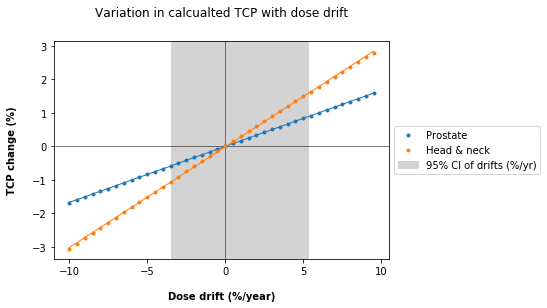

In [24]:
## plot the calcualted TCP (in percentage) against the dose drift (%/yr)

## define colours to use for each type
color_p = 'C0'
color_hn = 'C1'

tcp_percs_p = []
orig_tcp_p = res_p[0]['TCP_cure_percent']
tcp_percs_hn = []
orig_tcp_hn = res_hn[0]['TCP_cure_percent']

## get the dose drifts from the saved data
d_drifts = [i for i in res_p.keys()]

for i in d_drifts:
    ## prost
    the_tcp_p = res_p[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_p = ((the_tcp_p/orig_tcp_p)-1)*100
    tcp_percs_p.append(tcp_perc_dif_p)
    ## hn
    the_tcp_hn = res_hn[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_hn = ((the_tcp_hn/orig_tcp_hn)-1)*100
    tcp_percs_hn.append(tcp_perc_dif_hn)
    
plt.plot(d_drifts,tcp_percs_p,'o',ms=3,label='Prostate',color=color_p)
plt.plot(d_drifts,tcp_percs_hn,'o',ms=3,label='Head & neck',color=color_hn)
plt.title('Variation in calcualted TCP with dose drift')
plt.ylabel('TCP change (%)')
plt.xlabel('Dose drift (%/year)')

plt.axhline(0,color='black',lw=0.5,zorder=0)
plt.axvline(0,color='black',lw=0.5,zorder=0)

#plt.ylim(-40,40)

## add a polynomial...
## do the polynomial fit and create function from it

add_fit = True
if add_fit == True:
    for i in [tcp_percs_p,tcp_percs_hn]:
        coefs = poly.polyfit(d_drifts, i, 1)
        ffit = poly.Polynomial(coefs)
        if i == tcp_percs_p:
            fit_color = color=color_p
        else:
            fit_color = color=color_hn
        ## generate some x values and then plot the curve at these points
        x_fit = np.linspace(start=min(d_drifts),stop=max(d_drifts),num=100,endpoint=True)

        plt.plot(x_fit, ffit(x_fit),color=fit_color,lw=1,zorder=0)
    
## shade the regions of interest with different colours and labels
plt.axvspan(-3.5,5.3,alpha=1,color='lightgrey',zorder=0,label='95% CI of drifts (%/yr)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([-10,-5,0,5,10])

#plt.savefig('variation with dose drift-shade.png',dpi=300,bbox_inches='tight')
plt.show()

# Effect of treatment of different machines
- Same patient treated on 100 different machines with random dose delivery based on range of bem outputs (+cals).
- Get dose from uniform dist with SD = 0.7% (NPL only) and 1.0% (NPL + beam output).
    - Shade the 95% CI based on these 2 sets of data.
    - Probably want seperate plots for prostate and H&N.
    
    - Or can do boxplots of TCP for each 

In [139]:

##sds for normal distributions to use for NPL only and NPL + OPs
npl_sd = 0.7
npl_op_sd = 1.0

the_mean = 0 ## mean output
num = 1000 ## number of 'machines'

do_this = True
if do_this == True:
        
    ## generate output from normal distribution for both sets of SDs
    mean_ops_npl = np.random.normal(loc=the_mean,scale=npl_sd,size=num)
    mean_ops_npl_op = np.random.normal(loc=the_mean,scale=npl_op_sd,size=num)

    ## Prostate NPL only
    res_p_npl = []

    ## calc TCP and store for each factor (beam output)
    for the_d in mean_ops_npl:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=1.5,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 74)                # N0 as determnined through population fit
        ## save the TCP percentage to list
        res_p_npl.append(results['TCP_cure_percent'])

    print('Prostate NPL only done',np.std(p_doses_npl))
    
    

    ## H&N  NPL only
    res_hn_npl = []

    for the_d in mean_ops_npl:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=10,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=65/30,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 3000000)                # N0 as determnined through population fit
        res_hn_npl.append(results['TCP_cure_percent'])

    print('H&N NPL only done',np.std(hn_doses_npl))

    ## Prostate NPL + OP
    res_p_npl_op = []

    ## calc TCP and store for each factor (beam output)
    for the_d in mean_ops_npl_op:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=1.5,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 74)                # N0 as determnined through population fit
        ## save the TCP percentage to list
        res_p_npl_op.append(results['TCP_cure_percent'])

    print('Prostate NPL + OP done',np.std(p_doses_npl_op))
    

    ## H&N  NPL + OP
    res_hn_npl_op = []

    for the_d in mean_ops_npl_op:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=10,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=65/30,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 3000000)                # N0 as determnined through population fit
        res_hn_npl_op.append(results['TCP_cure_percent'])

    print('H&N NPL + OP done',np.std(hn_doses_npl_op))

Prostate NPL only done 0.014325523977
H&N NPL only done 0.0155193176417
Prostate NPL + OP done 0.0189384616473
H&N NPL + OP done 0.0205166667846


In [141]:
## Save/Load data

# save:
#save_pkl(res_p_npl,'p_d_machine_npl_var.pkl')
#save_pkl(res_hn_npl,'hn_d_machine_npl_var.pkl')
#save_pkl(res_p_npl_op,'p_d_machine_npl+op_var.pkl')
#save_pkl(res_hn_npl_op,'hn_d_machine_npl+op_var.pkl')

## load:
res_p_npl = load_pkl('p_d_machine_npl_var.pkl')
res_hn_npl = load_pkl('hn_d_machine_npl_var.pkl')
res_p_npl_op = load_pkl('p_d_machine_npl+op_var.pkl')
res_hn_npl_op = load_pkl('hn_d_machine_npl+op_var.pkl')



C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


2.33240534857
5.2262550218
3.40765211105
7.66356180382


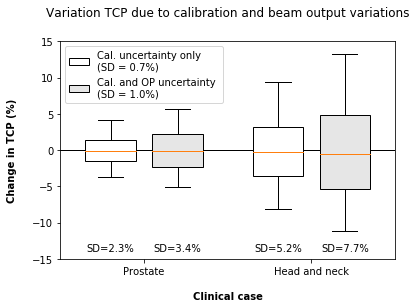

In [192]:
## convert each to percantage var from the mean
p_npl_perc = [100*(1-i/np.mean(res_p_npl)) for i in res_p_npl]
p_npl_op_perc = [100*(1-i/np.mean(res_p_npl_op)) for i in res_p_npl_op]
hn_npl_perc = [100*(1-i/np.mean(res_hn_npl)) for i in res_hn_npl]
hn_npl_op_perc = [100*(1-i/np.mean(res_hn_npl_op)) for i in res_hn_npl_op]

## there is n (1000) results within each set of saved data
## want boxplots of each...?

npl_data = [p_npl_perc,hn_npl_perc]
npl_op_data = [p_npl_op_perc,hn_npl_op_perc]

## combined plot - uses ax. so can get auto legend from colour of boxplots
fig, ax = plt.subplots()

offset = 0.2
width = 0.3
## left
bp1 = ax.boxplot(npl_data,vert=True,widths=width,whis=[5,95],sym='',showmeans=False,
            positions=[1-offset,2-offset], patch_artist=True,boxprops={'facecolor':'white','alpha':1})
## right
bp2 = ax.boxplot(npl_op_data,vert=True,widths=width,whis=[5,95],sym='',showmeans=False,
           positions=[1+offset,2+offset], patch_artist=True,boxprops={'facecolor':'#E6E6E6','alpha':1,'edgecolor':'black'})
plt.xticks([1,2],['Prostate', 'Head and neck'])
plt.xlim(0.5,2.5)

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Cal. uncertainty only \n(SD = 0.7%)', 'Cal. and OP uncertainty \n(SD = 1.0%)'])
plt.legend()

plt.axhline(0,color='black',lw=1,ls='-')
plt.ylim(-15,15)

#ax.set_ylim(0.5,2.5)
ax.set_ylabel('Change in TCP (%)')
ax.set_xlabel('Clinical case')
plt.title('Variation TCP due to calibration and beam output variations')

## add text with the SDs of each onto the plot
sd_vals = []

for i in [npl_data,npl_op_data]:
    for j in i:
        print(np.std(j))
        sd_vals.append(np.std(j))
        
text_x = [0.8,1.8,1.2,2.2] ## manually set

for i in range(len(text_x)):
    plt.text(text_x[i],-14,'SD='+str(round(sd_vals[i],1))+'%',horizontalalignment='center')


#plt.savefig('npl_vs_npl+op_uncertainty.png',dpi=300,bbox_inches='tight')
plt.show()

# Variation in TCP curve due to machine - entire TCP curve

### Same as above, but save the entire TCP curve
- base on dose due to normal distribution (apply to model as a dose shift)
- seperate plots for prostate and H&N (p='C1',hn='C1')
    - Only use variation from NPL+OP as more realistic clinical situation.

In [343]:
## generate 1000 random dose deviaitons from normal distribution
the_n = 1000
the_sd = 0.8
the_mean = 0
dose_shifts = np.random.normal(loc=the_mean,scale=the_sd,size=the_n)

## generate p + HN results for each of these dose shifts adn save the results

p_res = []
hn_res = []

do_this = True
if do_this == True:

    for the_d in dose_shifts:

        p_results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                          alphabeta_use=1.5,      # mean alpha/beta
                                          alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                          d=2,                    # nominal dose (Gy/fraction)
                                          d_shift=the_d,          # initial dose difference (%)
                                          d_sd=0,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 74) 


        hn_results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                          alphabeta_use=10,      # mean alpha/beta
                                          alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                          d=65/30,                    # nominal dose (Gy/fraction)
                                          d_shift=the_d,          # initial dose difference (%)
                                          d_sd=0,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 3000000)                # N0 as determnined through population fit

        p_res.append(p_results)
        hn_res.append(hn_results)


In [344]:
## Save/Load data

# save:
#save_pkl(p_res,'p_d_machine_only_var.pkl')
#save_pkl(hn_res,'hn_d_machine_only_var.pkl')


## load:
#p_machine = load_pkl('p_d_machine_only_var.pkl')
#hn_machine = load_pkl('hn_d_machine_only_var.pkl')

p_machine = p_res
hn_machine = hn_res


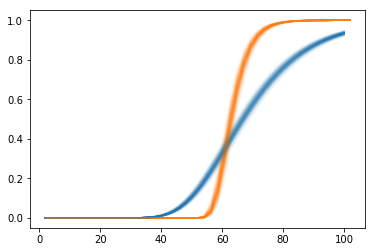

In [345]:
## plot all the TCP curves
for i in range(100):
    plt.plot(p_machine[i]['nom_doses'],p_machine[i]['TCP_pop'],c=color_p,alpha=0.05)
    plt.plot(hn_machine[i]['nom_doses'],hn_machine[i]['TCP_pop'],c=color_hn,alpha=0.05)
plt.show()

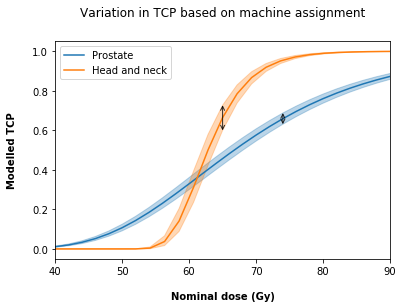

0.630740973357 0.687341301933
0.599500662863 0.726852893513


In [346]:
p_tcps = [p_machine[i]['TCP_pop'] for i in range(len(p_machine))]
p_nom_d = p_machine[0]['nom_doses']
p_tcp_mean = np.mean(p_tcps,axis=0)
p_tcp_5 = np.percentile(p_tcps,5,axis=0)
p_tcp_95 = np.percentile(p_tcps,95,axis=0)

hn_tcps = [hn_machine[i]['TCP_pop'] for i in range(len(hn_machine))]
hn_nom_d = hn_machine[0]['nom_doses']
hn_tcp_mean = np.mean(hn_tcps,axis=0)
hn_tcp_5 = np.percentile(hn_tcps,5,axis=0)
hn_tcp_95 = np.percentile(hn_tcps,95,axis=0)

plt.plot(p_nom_d,p_tcp_mean,label='Prostate',c=color_p)
#plt.plot(p_nom_d,p_tcp_5)
#plt.plot(p_nom_d,p_tcp_95)
plt.fill_between(p_nom_d,p_tcp_5,p_tcp_95,color=color_p,zorder=0,alpha=0.3)

plt.plot(hn_nom_d,hn_tcp_mean,label='Head and neck',c=color_hn)
#plt.plot(hn_nom_d,hn_tcp_5)
#plt.plot(hn_nom_d,hn_tcp_95)
plt.fill_between(hn_nom_d,hn_tcp_5,hn_tcp_95,color=color_hn,zorder=0,alpha=0.3)

plt.xlim(40,90)

plt.xlabel('Nominal dose (Gy)')
plt.ylabel('Modelled TCP')
plt.title('Variation in TCP based on machine assignment')

## show range of interest with arrows
## use annotate with no text as it seems easier
plt.annotate(s='', xy=(74,p_tcp_5[36]), xytext=(74,p_tcp_95[36]),
             arrowprops=dict(arrowstyle='<->',
                             shrinkA=0, shrinkB=0,
                             alpha=0.8))

plt.annotate(s='', xy=(65,hn_tcp_5[29]), xytext=(65,hn_tcp_95[29]),
             arrowprops=dict(arrowstyle='<->',
                             shrinkA=0, shrinkB=0,
                             alpha=0.8))

plt.legend()

#plt.savefig('tcp_95CI-p+hn.png',dpi=300,bbox_inches='tight')

plt.show()

## numerical results

print(p_tcp_5[36],p_tcp_95[36])
print(hn_tcp_5[29],hn_tcp_95[29])

In [6]:
## repeat the above with a number of different values for SD.

test_sds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4]

## do the below for each of the above SDs

## generate 1000 random dose deviaitons from normal distribution
the_n = 1000
the_sd = 0.8
the_mean = 0

sd_res = {}

for the_sd in test_sds:
    dose_shifts = np.random.normal(loc=the_mean,scale=the_sd,size=the_n)

    ## generate p + HN results for each of these dose shifts adn save the results

    p_res = []
    hn_res = []

    do_this = True
    if do_this == True:

        for the_d in dose_shifts:

            p_results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                              alphabeta_use=1.5,      # mean alpha/beta
                                              alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                              d=2,                    # nominal dose (Gy/fraction)
                                              d_shift=the_d,          # initial dose difference (%)
                                              d_sd=0,                 # standard deviation of delivered dose (%)
                                              d_trend=0,              # dose drift (%/day)
                                              max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                              dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                              n0 = 74) 


            hn_results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                              alphabeta_use=10,      # mean alpha/beta
                                              alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                              d=65/30,                    # nominal dose (Gy/fraction)
                                              d_shift=the_d,          # initial dose difference (%)
                                              d_sd=0,                 # standard deviation of delivered dose (%)
                                              d_trend=0,              # dose drift (%/day)
                                              max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                              dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                              n0 = 3000000)                # N0 as determnined through population fit

            p_res.append(p_results)
            hn_res.append(hn_results)
    
    sd_res[the_sd] = {'p':p_res,
                     'hn':hn_res}
    print(the_sd)


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4


In [7]:
#save_pkl(sd_res,'sd_var_results.pkl')
sd_res = load_pkl('sd_var_results.pkl')

In [8]:
sd_res[0.2]['hn'][0]['TCP_cure_percent']

66.362996077144558

0.1 prost 0.209800407812 hn 0.473086165937
0.2 prost 0.448153295564 hn 1.00943520992
0.3 prost 0.702021118292 hn 1.58157434412
0.4 prost 0.895913583137 hn 2.01741416699
0.5 prost 1.11490891004 hn 2.51515826982
0.6 prost 1.3197348919 hn 2.97384887937
0.7 prost 1.49626766261 hn 3.38705824347
0.8 prost 1.80944151739 hn 4.07443262916
0.9 prost 2.05903399947 hn 4.65131689876
1.0 prost 2.25051694635 hn 5.09913734425
1.1 prost 2.47420973836 hn 5.58484154531
1.2 prost 2.66376356809 hn 5.97690507859
1.3 prost 2.89451733226 hn 6.53523713773
1.4 prost 3.0374965708 hn 6.90581262507


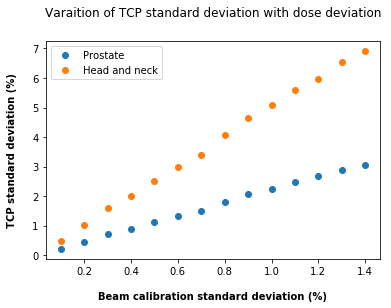

In [9]:
all_sd_p = []
all_sd_hn = []

for sd in test_sds:
    all_tcp_p = []
    all_tcp_hn = []
    for i in range(1000):
        all_tcp_p.append(sd_res[sd]['p'][i]['TCP_cure_percent'])
        all_tcp_hn.append(sd_res[sd]['hn'][i]['TCP_cure_percent'])
    sd_p = np.std(all_tcp_p)
    sd_hn = np.std(all_tcp_hn)
    print(sd,'prost',sd_p,'hn',sd_hn)
    all_sd_p.append(sd_p)
    all_sd_hn.append(sd_hn)

plt.plot(test_sds,all_sd_p,'o',label='Prostate')
plt.plot(test_sds,all_sd_hn,'o',label='Head and neck')
plt.legend()
plt.xlabel('Beam calibration standard deviation (%)')
plt.ylabel('TCP standard deviation (%)')
plt.title('Varaition of TCP standard deviation with dose deviation')
#plt.savefig('TCP_sd_var_with_mean_dose_var.png',dpi=300,bbox_inches='tight')
plt.show()

# Variation in dose due to daily variations only.
- Vary the d_sd value from 0 to ~3%
- The mean will stay the same, but now there will be a variation around this.
- Use a population of 1000 patients...?
- Plot whole TCP curve and table of stats


In [93]:
d_sds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] ## check range required.
d_sds = np.linspace(start = 0,stop = 2,num = 21,endpoint=True)

p_sd_res = {}
hn_sd_res = {}

for the_d in d_sds:

    p_results = model.completeTCPcalc(n=1000,                  # number of patients in population to model
                                      alphabeta_use=1.5,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=0,          # initial dose difference (%)
                                      d_sd=the_d,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 74) 


    hn_results = model.completeTCPcalc(n=1000,                  # number of patients in population to model
                                      alphabeta_use=10,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=65/30,                    # nominal dose (Gy/fraction)
                                      d_shift=0,          # initial dose difference (%)
                                      d_sd=the_d,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 3000000)                # N0 as determnined through population fit

    p_sd_res[the_d] = p_results
    hn_sd_res[the_d] = hn_results
    print(the_d)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0


In [95]:
#save_pkl(p_sd_res,'daily_dose_sd_var_p.pkl')
#save_pkl(hn_sd_res,'daily_dose_sd_var_hn.pkl')
p_sd_res = load_pkl('daily_dose_sd_var_p.pkl')
hn_sd_res = load_pkl('daily_dose_sd_var_hn.pkl')

sd: 0.0 p: 0.0 hn: 0.0
sd: 0.1 p: 0.06 hn: 0.14
sd: 0.2 p: 0.11 hn: 0.28
sd: 0.3 p: 0.16 hn: 0.39
sd: 0.4 p: 0.22 hn: 0.56
sd: 0.5 p: 0.28 hn: 0.7
sd: 0.6 p: 0.34 hn: 0.83
sd: 0.7 p: 0.4 hn: 0.99
sd: 0.8 p: 0.45 hn: 1.07
sd: 0.9 p: 0.48 hn: 1.28
sd: 1.0 p: 0.56 hn: 1.36
sd: 1.1 p: 0.61 hn: 1.48
sd: 1.2 p: 0.68 hn: 1.63
sd: 1.3 p: 0.73 hn: 1.81
sd: 1.4 p: 0.78 hn: 1.97
sd: 1.5 p: 0.83 hn: 2.06
sd: 1.6 p: 0.9 hn: 2.15
sd: 1.7 p: 0.96 hn: 2.36
sd: 1.8 p: 0.96 hn: 2.55
sd: 1.9 p: 1.05 hn: 2.69
sd: 2.0 p: 1.14 hn: 2.81


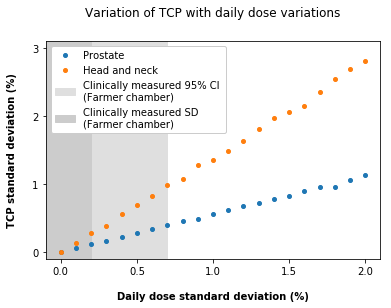

In [126]:
## now need to get teh SD of teh TCP at the required dose ([36] or [29])

the_sds = list(p_sd_res.keys())

all_sd_perc = {}


for the_sd in the_sds:

    ## get array of all TCP vals and use numpy to get sd from column
    p_tcp_vals = p_sd_res[the_sd]['TCPs']
    hn_tcp_vals = hn_sd_res[the_sd]['TCPs']

    p_tcp_sd = np.std(p_tcp_vals,axis=0) ## absolute SD
    hn_tcp_sd = np.std(hn_tcp_vals,axis=0) ## absolute SD

    p_tcp_mean = np.mean(p_tcp_vals,axis=0)
    hn_tcp_mean = np.mean(hn_tcp_vals,axis=0)

    ## convert to percentage
    p_tcp_sd_perc = 100*p_tcp_sd/p_tcp_mean
    hn_tcp_sd_perc = 100*hn_tcp_sd/hn_tcp_mean
    
    ## store the data at dose of interest
    all_sd_perc[the_sd] = {'p':p_tcp_sd_perc[36],
                          'hn':hn_tcp_sd_perc[29]}


## create plot of TCP sds vs dose sds
p_sds = []
hn_sds = []
plot_sds = []

for i in sorted(all_sd_perc):
    plot_sds.append(i)
    p_sds.append(all_sd_perc[i]['p'])
    hn_sds.append(all_sd_perc[i]['hn'])
    print('sd:',i,'p:',round(all_sd_perc[i]['p'],2),'hn:',round(all_sd_perc[i]['hn'],2))
    
plt.plot(plot_sds,p_sds,'o',color=color_p,label='Prostate',ms=4)
plt.plot(plot_sds,hn_sds,'o',color=color_hn,label='Head and neck',ms=4)

plt.title('Variation of TCP with daily dose variations')
plt.xlabel('Daily dose standard deviation (%)')
plt.ylabel('TCP standard deviation (%)')

plt.xticks([0,0.5,1,1.5,2])
plt.yticks([0,1,2,3])
plt.ylim(-0.1,3.1)

## shading

plt.axvspan(-1,0.7,alpha=1,color='#dfdfdf',zorder=0,label='Clinically measured 95% CI \n(Farmer chamber)')
plt.axvspan(-1,0.2,alpha=1,color='#cccccc',zorder=0,label='Clinically measured SD \n(Farmer chamber)')
plt.xlim(-0.1,2.1)

leg = plt.legend(loc='upper left')
leg.get_frame().set_alpha(1)

#plt.savefig('TCP_var_with_daily_sd_var.png',dpi=300,bbox_inches='tight')
plt.show()
